<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/3_planes_concatenate_DenseNet_transfer_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#!pip install pyyaml

In [ ]:

!pip install tensorflow
!pip install keras
!pip install h5py
!pip install sklearn
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from glob import glob
from IPython.display import Image, display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
pd.options.mode.chained_assignment = None  # default='warn'


## Data import

**import data and get labels**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train'
valid_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid'

In [ ]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['coronal', 'sagittal', 'axial']
diagnosis = ['meniscus']

In [ ]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data from the original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path

#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)

    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, plane_dir, label_data)

**meniscus dataset**

In [ ]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [ ]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [ ]:
train_sagittal_data[0]

'0048.npy'

In [ ]:
train_sagittal_dir

'/content/drive/My Drive/miniscus data set/MRNet-v1.0/train/sagittal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained.


## **data generation for meniscus**

In [ ]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transformf' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transformf' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


In [ ]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

(1130, 256, 256, 3)


In [ ]:
sagittal_mensicus_val.view

<function ndarray.view>

In [ ]:
from keras.utils import to_categorical  # Import to_categorical
base_path = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"

num_classes =2

sagittal_mensicus_label = to_categorical(sagittal_mensicus_label, num_classes)
sagittal_mensicus_label_val = to_categorical(sagittal_mensicus_label_val, num_classes)

coronal_mensicus_label = to_categorical(coronal_mensicus_label, num_classes)
coronal_mensicus_label_val = to_categorical(coronal_mensicus_label_val, num_classes)

axial_mensicus_label = to_categorical(axial_mensicus_label, num_classes)
axial_mensicus_label_val = to_categorical(axial_mensicus_label_val, num_classes)


In [ ]:

from sklearn.metrics import log_loss
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Transfer Learning

##  Hyperparameters

In [ ]:
    # Define your parameters
    img_rows, img_cols = 256, 256  # Adjust based on your actual image dimensions
    channel = 3
    num_classes = 2  # Binary classification
    batch_size = 32
    nb_epoch = 100
    dropout = 0.4
    lr = 5e-4  # Learning rat

## Model Creation and training

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling1D, Reshape, Flatten
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import ModelCheckpoint
def create_model2(input_shape, num_classes, dropout):
    # Base DenseNet model for each plane (axial, coronal, sagittal)
    base_model = DenseNet121(weights='imagenet', include_top=False, pooling=None, input_shape=input_shape)

    # Define input for each plane
    input_axial = Input(shape=input_shape, name='input_axial')
    input_coronal = Input(shape=input_shape, name='input_coronal')
    input_sagittal = Input(shape=input_shape, name='input_sagittal')

    # Process each plane using the same base DenseNet model
    axial_output = base_model(input_axial)
    coronal_output = base_model(input_coronal)
    sagittal_output = base_model(input_sagittal)

    # Global Average Pooling for each plane
    axial_output = GlobalAveragePooling2D()(axial_output)
    coronal_output = GlobalAveragePooling2D()(coronal_output)
    sagittal_output = GlobalAveragePooling2D()(sagittal_output)

    # Concatenate the outputs from all planes
    concatenated = Concatenate()([ axial_output, coronal_output, sagittal_output])

    # Dense and Dropout layers after concatenation
    x = BatchNormalization()(concatenated)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=[input_axial, input_coronal, input_sagittal], outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

if __name__ == '__main__':
    input_shape = (img_rows, img_cols, channel)
    model = create_model2(input_shape, num_classes, dropout)

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Train the model with axial, coronal, and sagittal planes
    history = model.fit([axial_meniscus, coronal_mensicus, sagittal_mensicus],
                        axial_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=([ axial_meniscus_val, coronal_mensicus_val, sagittal_mensicus_val], axial_mensicus_label_val),
                        callbacks=callbacks_list)

    # Evaluate the model
    predictions_valid = model.predict([ axial_meniscus_val, coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
    score = log_loss(axial_mensicus_label_val, predictions_valid)

    print(f"Log Loss: {score}")
    model.summary()


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.5192 - loss: 0.7957
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5208 - loss: 0.7946 - val_accuracy: 0.5667 - val_loss: 0.9249
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6167 - loss: 0.7340
Epoch 2: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.6166 - loss: 0.7337 - val_accuracy: 0.5667 - val_loss: 0.7345
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6199 - loss: 0.7062
Epoch 3: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.6200 - loss: 0.7061 - val_accuracy: 0.5667 - val_loss: 0.7038
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6635 - loss: 0.6811
Epoch 4: val_accuracy improved from 0.56667 to 0.57500, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 7

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_coronal             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sagittal            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 8, 8, 1024)     │      7,037,504 │ input_coronal[0][0],   │
│                           │                        │                │ input_sagittal[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[1][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13            │ (None, 2048)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 2048)           │          8,192 │ concatenate_13[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 2048)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 1024)           │      2,098,176 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 1024)           │              0 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 512)            │        524,800 │ dropout_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 2)              │          1,026 │ dense_36[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,297,798 (46.91 MB)

 Trainable params: 2,628,098 (10.03 MB)

 Non-trainable params: 7,041,600 (26.86 MB)

 Optimizer params: 2,628,100 (10.03 MB)

## Model evaluation

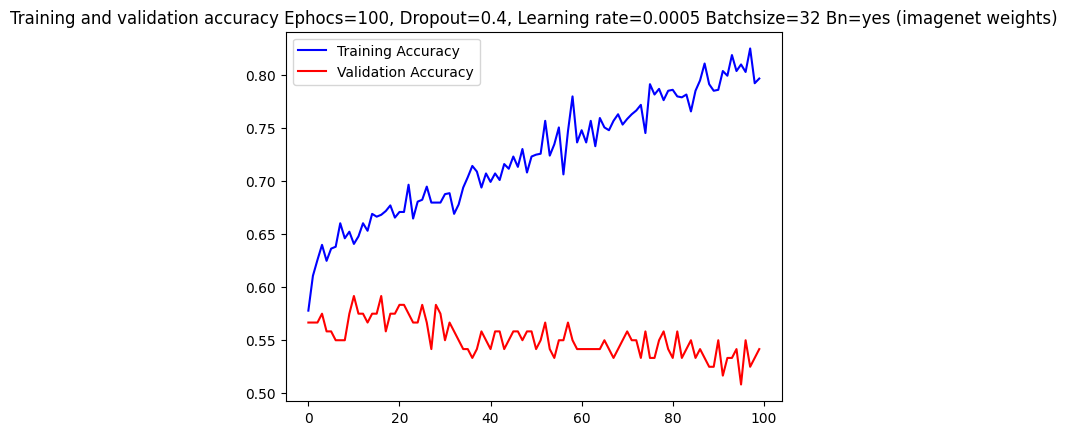

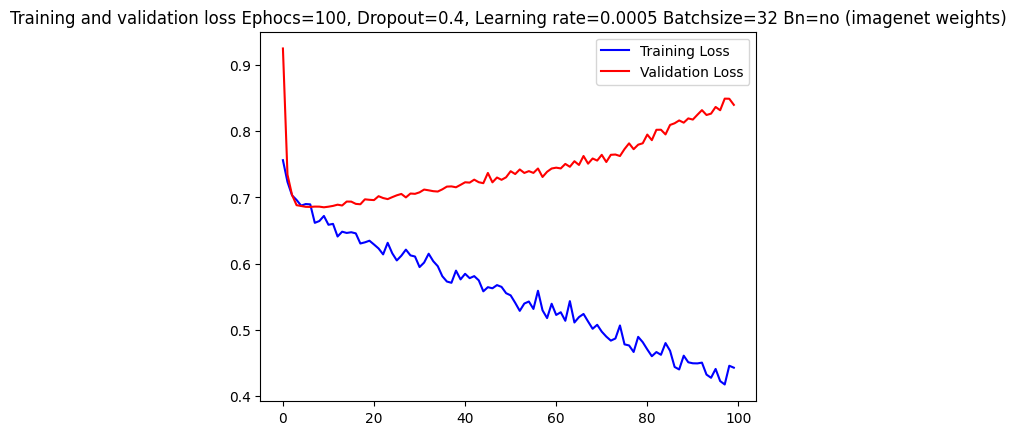

In [ ]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title(f'Training and validation accuracy Ephocs={nb_epoch}, Dropout={dropout}, Learning rate={lr} Batchsize={batch_size} Bn=yes (imagenet weights)')

plt.legend()
plt.savefig(f'Train_val_acc_Ep={nb_epoch}_Do={dropout}_Lr={lr}_Bs={batch_size}_Bn=no (imagenet weights).png')

plt.figure()


#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')

plt.title(f'Training and validation loss Ephocs={nb_epoch}, Dropout={dropout}, Learning rate={lr} Batchsize={batch_size} Bn=no (imagenet weights)')
plt.savefig(f'Train_val_loss_Ep={nb_epoch}_Do={dropout}_Lr={lr}_Bs={batch_size}_Bn=no (imagenet weights).png')

plt.legend()

plt.show()


In [ ]:
# Function to calculate accuracy and misclassification
def calculate_accuracy(ypred, ytest):
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(ytest[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1

    accuracy = round(accurate / total * 100, 3)
    return total, accurate, total - accurate, accuracy, accurateindex, wrongindex

In [ ]:

# Axial plane accuracy
total_axial, accurate_axial, wrong_axial, accuracy_axial, accurateindex_axial, wrongindex_axial = calculate_accuracy(predictions_valid, axial_mensicus_label_val)
print(' - Total test data:', total_axial, '\tAccurately predicted data:', accurate_axial, '\tWrongly predicted data:', wrong_axial)
print('Axial Accuracy:', accuracy_axial, '%')

Axial - Total test data: 120 	Accurately predicted data: 65 	Wrongly predicted data: 55
Axial Accuracy: 54.167 %
